In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('./data/training_data.csv')

In [3]:
# encode resolution_time_group

mapping = ['day', 'week', 'month', 'year','> year']
df['resolution_time_group'] = df['resolution_time_group'].map(lambda x: mapping.index(x))

In [4]:
X = df.drop(['resolution_time_group'], axis=1)
y = df['resolution_time_group']

In [5]:
# use torch, crate DataSet, then DataLoader
import torch
from torch.utils.data import TensorDataset, DataLoader

class Dataset(TensorDataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.tensor(X.values).float()
        self.y = torch.tensor(y.values).long()

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.y)
    
dataset = Dataset(X, y)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [10]:

# create model
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = Net(X.shape[1], 100, 5)

In [11]:
# cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Training: 100%|██████████| 10/10 [13:02<00:00, 78.25s/it]


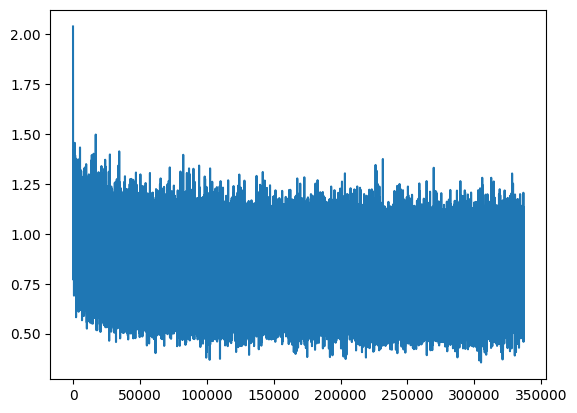

In [12]:

# train model
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []

from tqdm import tqdm

for epoch in tqdm(range(10), desc='Training'):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

plt.plot(losses)
plt.show()
    

In [13]:
# accuracy
from sklearn.metrics import accuracy_score

y_pred = model(torch.tensor(X.values).float())
y_pred = y_pred.argmax(dim=1)
y_pred = y_pred.detach().numpy()
print(accuracy_score(y, y_pred))

0.706860885135251
